In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!apt-get install -y xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.12).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

Iterations that were run: 22


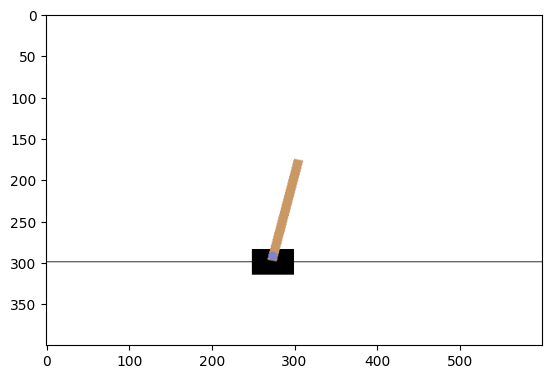

In [ ]:
import time

env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50000):
  action = env.action_space.sample()
  print("step i",i,"action=",action)
  obs, reward, done, info = env.step(action)
  print("obs=",obs,"reward=",reward,"done=",done,"info=",info)
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)

  #time.sleep(1)

  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()
print("Iterations that were run:",i)

In [ ]:
'''
 For Exercise 1, DP in Assignment 1 seems not to be applicable to the CartPole.
 DP relies on the complete model of the environment (mainly the transition probability), which in the previous assignment is given by env.P[state][action].
 But it is unknown and difficult to obtain in the CartPole case.
 Actually, I tried to discretize and modify the code I wrote last time, but there were always errors about index, attribute and so on.
 So in short, model-free algorithms such as MC suits the CartPole much more better.
 MC code for Exercise 2 is written below.
'''

Reward using trained policy: 49.0


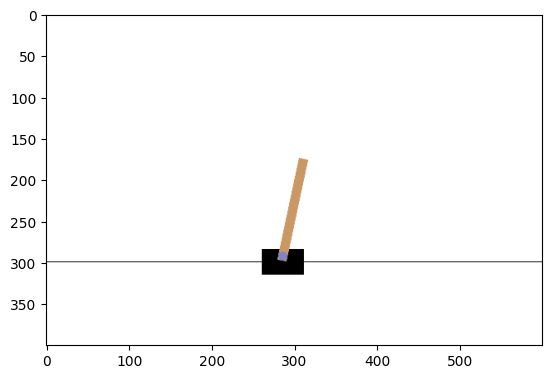

In [ ]:
# Discretization
def discretize_state(state, bins):

  cart_pos_bin = np.digitize(state[0], bins[0])
  cart_vel_bin = np.digitize(state[1], bins[1])
  pole_ang_bin = np.digitize(state[2], bins[2])
  pole_vel_bin = np.digitize(state[3], bins[3])

  return (cart_pos_bin, cart_vel_bin, pole_ang_bin, pole_vel_bin)

bins = [
  np.linspace(-2.4, 2.4, 4),     # car position
  np.linspace(-2, 2, 8),       # car velocity
  np.linspace(-0.2095, 0.2095, 10),  # pole angle
  np.linspace(-5, 5, 10)       # pole angular velocity
]

env = gym.make("CartPole-v0")
stateSpaceSize = (len(bins[0])+1, len(bins[1])+1, len(bins[2])+1, len(bins[3])+1)
actionSpaceSize = env.action_space.n
Q = np.zeros(stateSpaceSize + (actionSpaceSize,))
returns, gamma, episodes, epsilon = {}, 0.99, 10000, 0.1

for episode in range(episodes):
  # Initialization
  random_state = discretize_state(env.observation_space.sample(), bins)
  random_action = np.random.choice(actionSpaceSize)
  episode_data = [(random_state, random_action, 0)]  # (state, action, reward)

  state = env.reset()
  state = discretize_state(state, bins)
  done = False

  # Epsilon-greedy policy
  while not done:
    if np.random.rand() > epsilon:
      action = np.argmax(Q[state])
    else:
      action = np.random.choice(actionSpaceSize)
    next_state, reward, done, _ = env.step(action)
    next_state = discretize_state(next_state, bins)
    episode_data.append((next_state, action, reward))
    state = next_state

  # First-visit
  G = 0
  visited = np.zeros(stateSpaceSize + (actionSpaceSize,), dtype=bool)
  for t in reversed(range(len(episode_data))):
    state, action, reward = episode_data[t]
    G = reward + gamma * G
    if not visited[state][action]:
      visited[state][action] = True
      if (state, action) not in returns:
        returns[(state, action)] = []
      returns[(state, action)].append(G)
      Q[state][action] = np.mean(returns[(state, action)])

state = env.reset()
state = discretize_state(state, bins)
done = False
i, total_reward = 0, 0
while not done:
  env.render()
  action = np.argmax(Q[state])
  print("step i",i,"action=",action)
  i += 1
  state, reward, done, info = env.step(action)
  print("obs=",state,"reward=",reward,"done=",done,"info=",info)
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())
  state = discretize_state(state, bins)
  total_reward += reward
ipythondisplay.clear_output(wait=True)
print('Reward using trained policy:', total_reward)
env.close()


I have followed the process of on-policy first-visit MC control (for epsilon-soft policies) in the above code, including initialization, generating episodes, looping, and epsilon-greedy policy.
When we take random actions, the reward is usually around 20.
With the help of MC, we can reach 40+ within 10000 episodes.
This is of course not enough, as I have divided into 3200 states, the episode number cannot guarantee all states to be visited.
More episodes require longer time, but will further improve the performance.